# Stolen Cycles: A Bicycle Theft LocalizationTool 

## DATS 6103 Individual Project 3 : Mariko McDougall

### Notebook 2/2 : User Location Maps and Threat Plots

*This notebook uses the database downloaded in notebook 1/2: Web Scraper and Updater to visualize areas of high bike theft, based on user input. *

This tool allows users to input their current location, and receive the location and recency of nearby bike thefts. This allows users to make informed decisions prior to leaving their bicycle unattended.

This analysis was performed for GWU's DATS 6103 - Introduction to Data Mining. 
The purpose of this analysis is to extract and examine data using publicly available datasets and draw conclusions, as well as make predictions using the findings.

All data sourcing, wrangling and analysis was performed in python using publicly available libraries.

## Imports and Dataset Loading

In [1]:
#Non-Specific Imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime as datetimeOverlap

#Geolocators, Cartopy and Map Plotting
from geopy.geocoders import Nominatim
from geopy.geocoders import Photon
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
from matplotlib import cm
from matplotlib.colors import Normalize


#Set Pandas options
pd.set_option('display.max_columns', 10)
pd.options.mode.chained_assignment = None 


#Set the working directory
wd=os.path.abspath('C://Users//Mariko//Documents//GitHub//BicycleTheft-DATS6103')
os.chdir(wd)

In [2]:
"""
Load the database from file
"""

main_df = pd.read_csv(f'./Data/Main_Database.csv', index_col=0,  parse_dates=['DateTime'])



## Geolocator and Mapping Functions

In [3]:

def get_user_loc(street_address):
    """
    Takes a user input and convert it to a geopy location.
    Does not have to be an exact address - can be as simple as "Seattle".
    """
    
    #Load the geolocators    
    geolocator_nominatim = Nominatim(user_agent="BikeThefts")
    geolocator_photon = Photon(user_agent="BikeThefts")
    
    #First check photon - most reliable
    location = geolocator_photon.geocode(street_address)
    
    #Check if Photon found the address
    if location is None: 
        #Photon failed - attempt Nominatim
        location = geolocator_nominatim.geocode(street_address)
    
    #Both have failed, return to user for error checking.    
    if location is None:
        raise ValueError(f"\n Address not found. Please ensure that you have entered a valid address.\n Previous Entry: {street_address}\n ")
        
    return location



def scrub_states(main_df):
    """
    Check to see if all states were accurately generated originally, and do a 
    more through parse if they are incorrect. Remove entries if they cannot be fixed.
    Return corrected dataframe
    """
    state_abbrev=['AL', 'AK', 'AS', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'GU', 'HI', 'ID', 'IL', 'IN',
            'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM',
            'NY', 'NC', 'ND', 'MP', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VI', 'VA',
            'WA', 'WV', 'WI', 'WY']
    
    #Seperate out the entries that did not parse correctly originally
    misparsed=main_df[(~main_df.State.isin(state_abbrev)) | (main_df.State == 'NE')]
    
    #Manually extract the states from the user entered locations
    misparsed['State']=misparsed.Location.str.split(',').str[-1].str.strip().str.split(' ').str[0]
    #Fiter out entries that are not states, even with the re-filter
    fixed = misparsed[misparsed.State.isin(state_abbrev)]
    
    #Re-merge into the main dataframe
    main_df=pd.concat([main_df[(main_df.State.isin(state_abbrev) & (main_df.State != 'NE'))], fixed])
    
    return main_df





def thefts_in_radius(user_loc, main_df, search_radius=10, return_nonspecifics=False):
    """
    Finds nearby theft locations within a set search radius(in miles)
    Note: raidus may vary depending on longitude of user - users closer to the equator will have slightly larger radii
    If return non-specifics is true, will also return all the places that don't have a specific address.
    This is helpful for the total number of thefts in the city.
    """

    #Latitude and longitude have different conversion raitios - must be handled seperately
    lat_radius = 1/69 * search_radius
    long_radius = 1/54.6 * search_radius
    
    #Set these as vairables to increase readablility
    user_lat=user_loc.latitude
    user_long=user_loc.longitude
    
    #Filter the main database to only include known latitudes and longitudes
    limited_df = main_df[main_df["Latitude"] != 'None']
    limited_df["Latitude"] =limited_df["Latitude"].astype(float)
    limited_df["Longitude"] =limited_df["Longitude"].astype(float)
    
    #Filter to limit data to those thefts within the maxium radii
    limited_df = limited_df[
            ((limited_df["Latitude"]>=(user_lat-lat_radius)) & (limited_df["Latitude"]<=(user_lat+lat_radius))) &
            ((limited_df["Longitude"]>=(user_long-long_radius)) & (limited_df["Longitude"]<=(user_long+long_radius)))
            ]
    
    
    #Now, need to calculate how far that theft is from the user location
    #(The above may be farther away than the search value, if they are at maximum lat/long, but have additional long/lat)
    
    #Triangulate using the pythagorian formula, converting distances back into miles
    limited_df['Distance'] = ((user_long-limited_df["Longitude"])*54.6)**2 + ((user_lat-limited_df["Latitude"])*69)**2
    limited_df['Distance'] = np.sqrt(limited_df['Distance'])
    
    #Filter results down to those within the search radius
    in_radius_df=limited_df[limited_df["Distance"] <= search_radius]
    
    #nonspecific location processing
    if return_nonspecifics == True:
        non_specifics = main_df[main_df["Latitude"] == 'None']
        #Make sure that the city is in the correct state (using one of the filtered state results)
        non_specifics = non_specifics[non_specifics.State == limited_df.State.iloc[0] ]
        non_specifics['Distance'] = search_radius
        
        in_radius_df=pd.concat([in_radius_df, non_specifics])
    
    return in_radius_df




def calculate_risk(thefts_in_radius_df):
    """
    Need to incorperate several risk factors
    ----------------
    Recency of theft
    Distance from theft
    If locks were circumvented, and what kind of lock (ranked in terms of security, higher rank = more threat)

    Additional threat metric that discludes distance, to compare overall city crime to local crime.
    """
    
    threat_df=thefts_in_radius_df.copy()
    
    #All the locking options available in the theft reporting section
    #1: Not secured/Unknown, 2:Secured, 3:Well Secured
    security_rankings={1:['None', 'Not locked','Other'],
                       2:['U-lock and cable', 'Chain with padlock','U-lock', 'Cable lock'],
                       3:['Heavy duty bicycle security chain', 'Two U-locks'],
                       }
    
    #Reverse the dictionary - written in other format for readability
    security_rankings_inv={}
    for key in security_rankings:
        for i in security_rankings[key]:
            security_rankings_inv[i] = key
    
    #Apply the dictionary to the user-reported locking description
    security_threat = threat_df['Locking description'].replace(security_rankings_inv)
    
    
    #Distance - Threat decreases the farther the theft occured
    dist_threat = 10/threat_df['Distance']
    
    
    #Recency - Threat decreases the more time has elapsed since the theft occured
    days_since_theft = (datetimeOverlap.now()-threat_df['DateTime']).dt.days
    days_threat = 10/(0.01+days_since_theft)
    
    #Combine the threat metrics
    overall_threat = security_threat * dist_threat * days_threat
    lock_time = security_threat * days_threat 

    #Add the calculated values as columns and return
    threat_df["Lock_Status"] = security_threat
    threat_df["Time_Status"] = days_since_theft
    threat_df["Threat_Overall"] =overall_threat
    threat_df["Lock_Time"] =lock_time
    
    return threat_df

In [4]:

def theft_plot_transform(theft_nearby_df, labels=False):
    """
    Transforms the theft nearby dataframe into colours/radii for plotting individual thefts
    
    """

    #Set a normalization for assigning the colour gradient
    #A little larger than the cut-off, since the yellow in the chosen 'autumn' gradient end is hard to see.
    norm = Normalize(vmin=0, vmax=185)
    
    #Useses the normalization to generate the labels for plot
    if labels==True:
        return [ cm.autumn(norm(i),) for i in [30,60,90,180]]
    
    #Filter unneeded values
    theft_plot=theft_nearby_df.copy()
    theft_plot=theft_plot.filter(['Bike ID','Latitude',
                                  'Longitude', 'DateTime', 'Distance', 'Lock_Status',
                                  'Time_Status', 'Threat_Overall'])
    
    #Create a count of all bikes stolen at unique locations and dates
    loc_counts = theft_plot.groupby(['Longitude', 'Latitude', 'Time_Status']).size().reset_index(name='Theft_Count')   
    lock_counts = theft_plot.groupby(['Longitude', 'Latitude', 'Time_Status'])["Lock_Status"].mean().reset_index()
    loc_counts["Lock_Status"] = lock_counts["Lock_Status"].apply(lambda x: int(round(x,0))) 
    
    #Set default values
    theft_plot['Color']= 'Grey'
    theft_plot['Number']= 1
    
    #Loop through
    for i in range(theft_plot.shape[0]):
        theft = theft_plot.iloc[i, :]
        
        #If recent, change colour along gradient, else leave as grey
        if theft["Time_Status"]<=180:
            theft_plot['Color'].iloc[i] = cm.autumn(norm(theft["Time_Status"]),)
        
        #Compare to thefts at that exact location within a week of the theft
        #Used to mark out repeated hits, or bike cage break-ins (steal many bikes)
        count_here = loc_counts[(loc_counts.Longitude == theft.Longitude) &
                                (loc_counts.Latitude == theft.Latitude) &
                                ((loc_counts.Time_Status <= theft.Time_Status+7) & (loc_counts.Time_Status >= theft.Time_Status-7))]
        theft_plot['Number'].iloc[i] = count_here['Theft_Count'].sum()
        try:
            theft_plot["Lock_Status"].iloc[i] = int(round(count_here["Lock_Status"].mean()))
        except:
            pass
        
    
    #Drop duplicate entries - already recorded the number of thefts, do not need the extras
    theft_plot = theft_plot.drop_duplicates(['Longitude', 'Latitude','Number']) 
    
    #Put an upper limit on the number of thefts that get plotted
    #If you don't, a single large bike cage theft (~10 bikes) will fill the entire map
    theft_plot['Number']=theft_plot['Number'].apply(lambda x: 3 if x >= 3 else x)    

    return theft_plot





def plot_nearby_thefts(theft_nearby, user_loc, scale='small'): 
    """
    Plots all nearby bike thefts in a map catered on the user's location
    Bike thefts are denoted by markers with a radius showing # of bikes stolen, and colour showing recency of theft (red -> yellow)
    Bikes stolen > 6 months ago are plotted in grey.
    
    Background image for the map is a streetmap from OpenStreetMaps
    Some versions of cartopy are have a known bug when accessing OSM, related to the google tiles code. 
    If this occurs, please follow the guide below, or replace your cartopy file with the one provided.
    https://stackoverflow.com/questions/57531716/valueerror-a-non-empty-list-of-tiles-should-be-provided-to-merge-cartopy-osm
    """    

    #Set radius of the plot
    size_adj= {'small':[0.5,16],
               'medium':[1,15], 
               'large':[2, 14],
               }
    
    if scale.lower() not in size_adj.keys():
        raise ValueError(f"Please make sure your scale is set to Small, Medium or Large.")

    size=size_adj[scale.lower()]
    
    if theft_nearby.shape[0]>0:
        #Get the radii and colours for all thefts
        theft_plot = theft_plot_transform(theft_nearby)
    
    #Initiate the figure
    
    fig = plt.figure(figsize=(18,17))
    
    #The base map will be from Open Street Maps
    imagery = OSM()
    
    #Use the OSM projection for positioning lat/longitude points
    ax = plt.axes(projection=imagery.crs, )
    
    # Set the extent - center on the user location +/- 1 mile
    long_adj = 1/54.6 * size[0]
    lat_adj  = 1/69 * size[0]
    ax.set_extent( (user_loc.longitude-long_adj, user_loc.longitude+long_adj,
                    user_loc.latitude-lat_adj, user_loc.latitude+lat_adj))
    
    
    #Plot the user location
    plt.plot(user_loc.longitude,user_loc.latitude, color='red', markersize=30, marker='*',transform=ccrs.Geodetic() )
    plt.plot(user_loc.longitude,user_loc.latitude, color='white', markersize=18, marker='*',transform=ccrs.Geodetic() )
    
    if theft_nearby.shape[0]>0:
        #Plot all nearby bike thefts
        for i in range(theft_plot.shape[0]):
            plt.plot(theft_plot['Longitude'].iloc[i],theft_plot['Latitude'].iloc[i], color=theft_plot['Color'].iloc[i], markersize=theft_plot['Number'].iloc[i] * 35, marker='o', alpha=0.4, transform=ccrs.Geodetic() )
            plt.plot(theft_plot['Longitude'].iloc[i],theft_plot['Latitude'].iloc[i], color=theft_plot['Color'].iloc[i], markersize=10, marker='o',transform=ccrs.Geodetic() )
            
    
    # Add the imagery to the map.
    zoom = size[1] #15 is best for 1 mile 
    ax.add_image(imagery, zoom )
    plt.title(f'Bike thefts within {size[0]} Mile of {user_loc.address.split(",")[0]}')
    
    
      #Get colors and labels for the legend
    labels=theft_plot_transform(theft_nearby, labels=True)+['Grey']
    label_text=['<1 month', '2 Months', '3 Months', '4 Months', '>4 Months']
    theft_text=['1 Theft (1/3 size)','2 Thefts (1/3 size)', '3+ Thefts (1/3 size)',]
    
    #Add dummy axis to construct our legend
    legend_ax = fig.add_axes([1.01,0.6,0,0])
    legend_ax.axes.get_xaxis().set_visible(False)
    legend_ax.axes.get_yaxis().set_visible(False)
    
    #Add markers to dummy axis
    for i in range(len(labels)):
        legend_ax.plot(1,1, color=labels[i], label=label_text[i], markersize=10, marker='o',linestyle = 'None',)
       
    for i in range(1,4):
        legend_ax.plot(1,1, color='Grey', label=theft_text[i-1],
                       markersize=i*10, marker='o',linestyle = 'None', alpha=0.4)
    #Add legend
    legend_ax.legend(borderpad=1, labelspacing =1.8, columnspacing =2,)#bbox_to_anchor=(1.05, .7) )

    
    
    plt.show()
    
    


## Threat Assessment Readout Function

In [5]:

def risk_readout(user_loc, extra_plots=False):
    
    """
    Look at relative risk - your location vs 1 mile vs city
    """
    
    #Local theft
    
    theft_nearby=thefts_in_radius(user_loc, main_df, search_radius=0.5)
    theft_nearby=calculate_risk(theft_nearby)
    safety_nearby=theft_nearby["Lock_Time"].mean()
    
    #1 Mile Theft
    
    theft_local=thefts_in_radius(user_loc, main_df, search_radius=1)
    theft_local=calculate_risk(theft_local)
    safety_local=theft_local["Lock_Time"].mean()
    
    #City theft
    
    #Infer the city from the most common local theft city
    city=theft_local.City.value_counts().head(1).reset_index()
    city_df=main_df[main_df["City"]==city['index'].iloc[0]]
    theft_city = thefts_in_radius(user_loc, city_df, search_radius=15, return_nonspecifics=True)
    theft_city=calculate_risk(theft_city)
    safety_city=theft_city["Lock_Time"].mean()
    
    
    
    
    def category_diff(diff):
        
        if diff < -0.1:
            text='significantly less'
        elif diff < -0.05:
            text='less'
        elif diff < 0:
            text='slightly less'
        elif diff < 0.05:
            text='slightly more'
        elif diff < 0.1:
            text='more'
        else:
            text='significantly more'
    
        return text
        
    
    print('#  -----------  Relative Safety   -----------  #\n')
    print(f'  Your location is {category_diff(safety_local - safety_nearby)} safe than the local area.')
    print(f'  Your location is {category_diff(safety_city - safety_nearby)} safe than the city in general.')
    
    print('\n')
    
    
    per_nearby = (theft_nearby.shape[0]/theft_city.shape[0]) * 100
    per_local = (theft_local.shape[0]/theft_city.shape[0]) * 100
    
    print('#  -----------  Local Stats   -----------  #\n')
    print(f" {round(per_nearby, 1)}% of bike thefts occurred within 0.5 miles. ({theft_nearby.shape[0]}/{theft_city.shape[0]})")
    print(f" {round(per_local, 1)}% of bike thefts occurred within 1 mile. ({theft_local.shape[0]}/{theft_city.shape[0]})")
    
    
    
    locks_nearby = theft_nearby[theft_nearby['Locking description']!='None']
    locks_nearby=locks_nearby['Lock_Status'].value_counts()
    
    
    security_lvl={}
    for i in [1,2,3]:
        try:
            security_lvl[i]=locks_nearby[i]
        except:
            security_lvl[i]=0
    
    
    print(f'')
    print(f' {security_lvl[2] + security_lvl[3]}/{theft_nearby.shape[0]} Bikes were locked.' )
    print(f' {security_lvl[3]}/{theft_nearby.shape[0]} Bikes were highly secured.' )
    print(f' {security_lvl[1]}/{theft_nearby.shape[0]} Bikes were explicitly unlocked.' )
    print(f' {theft_nearby.shape[0] - sum(security_lvl.values())}/{theft_nearby.shape[0]} Bikes were unknown status.' )
    
    
    
    theft_nearby["Time_Status"].mean()
    theft_nearby["Distance"].mean()
    
    print()
    print(f' Closest stolen bike: {round(theft_nearby["Distance"].min(), 2)} miles.')
    print(f' Average stolen bike: {round(theft_nearby["Distance"].mean(), 2)} miles.')
    print()
    print(f' Most recent theft: {int(round(theft_nearby["Time_Status"].min(), 0))} days.')
    print(f' Mean time to theft: {int(round(theft_nearby["Time_Status"].mean(), 0))} days.')
    print('\n')
    
    
    
    
    print('#  -----------  OVERALL RECOMMENDATION   -----------  #\n')
    
    if  (safety_city-safety_nearby < -0.1) or (safety_city-safety_local < -0.1):
        print('     ---------------------------------------------\n')
        print('                        WARNING:')
        print(f"         Your current location is in a area prone to theft.")
        print(f'         High security locks are reccomended.')
        print('\n     ---------------------------------------------\n')
    
    if  safety_local - safety_nearby  < -0.03:
        print('This area is unusually high in theft compared to the local area.')
        print('Consider parking a 10-15 min walk away.')
    
    else:
        print(' Your current area is safer, or has similar theft risk to the local area.')
        print(' There is no need to park elsewhere.')
    
    print('\n As always, exercise caution and lock your bike.\n')
    
    print('#  -------------------------------------------------  #\n')
    
    
    def local_readout(theft_nearby,theft_local, theft_city ):
        #Label and merge the near, local and city datasets
        theft_nearby["Category"] = "Nearby \n<0.5 Miles"
        theft_local["Category"] = "Local \n<1 Mile"
        theft_city["Category"] = "City"
        theft_plot=pd.concat([theft_nearby,theft_local,theft_city])


        #Generate a plot showing the distribution of days since theft
        fig = plt.figure(figsize=(5,5))
        sns.boxenplot(data=theft_plot, x='Category', y='Time_Status',)# inner='box',cut=0)
        plt.ylabel("Days Since Theft")
        plt.ylim(0)
        plt.xlabel('')
        plt.title("Distribution of Days since Theft")
        plt.show()



        #Generate a plot comparing the bike security levels in the area vs the whole city
        #Make the loc status categorical, and add an "Unknown" category
        for i in range(theft_plot.shape[0]):
            if theft_plot['Locking description'].iloc[i] =='None':
                theft_plot['Lock_Status'].iloc[i] = 0

        theft_plot['Lock_Status']=theft_plot['Lock_Status'].replace({0:'Unknown', 1:"Unlocked", 2:"Secured", 3:"Very Secured"})    

        #Generate the countplot for the security data
        fig = plt.figure(figsize=(4,4))
        ax = sns.countplot(data=theft_plot,  hue='Lock_Status', x='Category')
        ax.set_yscale("log")
        plt.ylabel("Log # Bikes ")
        plt.xlabel('')
        plt.legend(title = "Security Level",  bbox_to_anchor=(1.05, .7))
        plt.title("Bike Security Level in the Local Area")
        plt.show()
        
    if extra_plots == True:
        local_readout(theft_nearby,theft_local, theft_city)

In [6]:

def search_near_me(user_street_address, scale='small', extra_plots=False,  main_df=main_df):
    """
    Wrapper function to wrap all of the golocator, threat assessment and mapping functions
    Inputs:
    user_street_address: The address to be searched. Can be an exact address, or a city name.
    scale: How large a radius around the street address to display on the output map. 
            Small: 1/2 mile radius
            Medium: 1 mile radius
            Large: 2 mile radius
    extra_plots: Show some of the threat assessment information as additional plots comparing the
                 current area to a 1 mile radius and the city as a whole.
    main_df: The dataframe to be passed to analyze thefts
    """
    
    size_adj= {'small':0.5,'medium':1,'large':2,}
    
    if scale.lower() not in size_adj.keys():
        raise ValueError(f"Please make sure your scale is set to Small, Medium or Large.")
    
    
    user_loc=get_user_loc(user_street_address)    

    theft_nearby=thefts_in_radius(user_loc, main_df, search_radius=size_adj[scale.lower()])
    
    theft_nearby=calculate_risk(theft_nearby)

    plot_nearby_thefts(theft_nearby, user_loc, scale)
    
    risk_readout(user_loc, extra_plots)        
    
    return theft_nearby

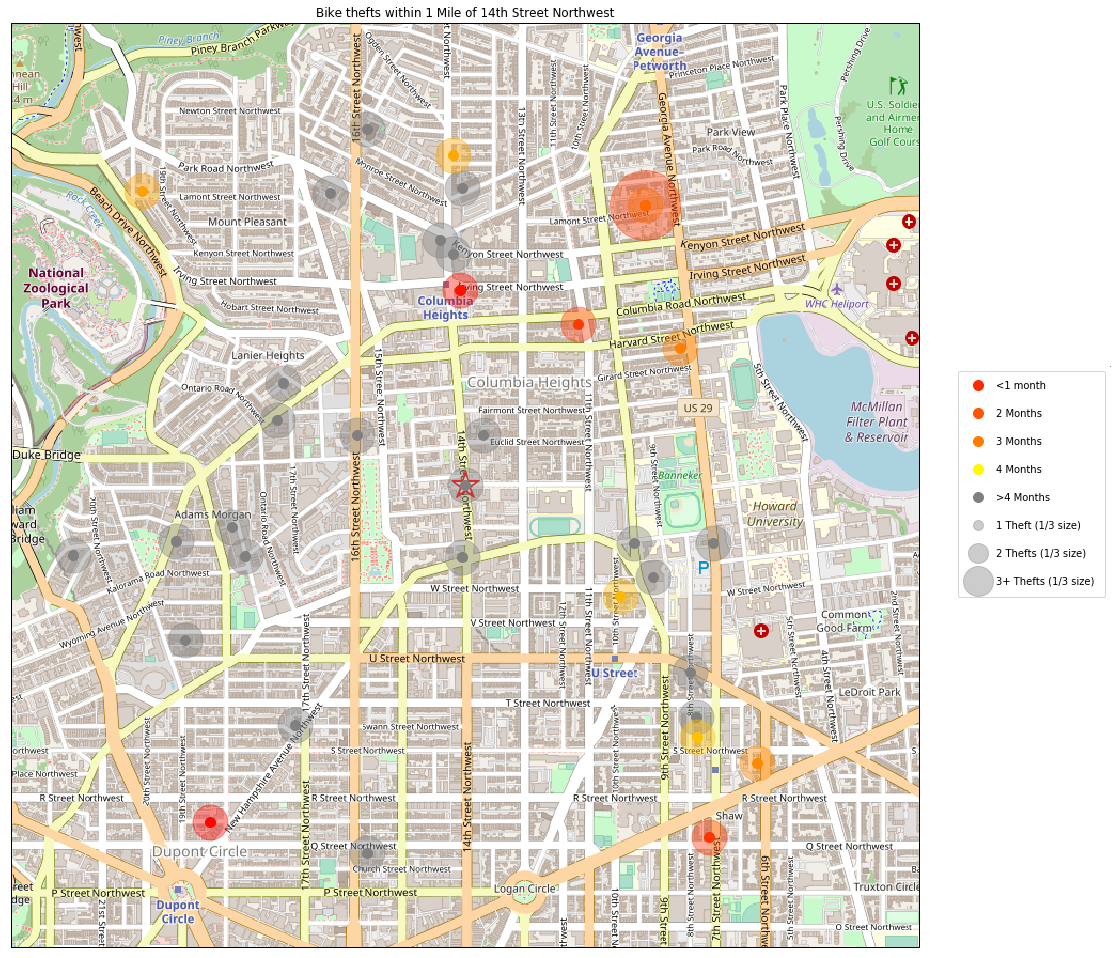

#  -----------  Relative Safety   -----------  #

  Your location is significantly more safe than the local area.
  Your location is less safe than the city in general.


#  -----------  Local Stats   -----------  #

 0.8% of bike thefts occurred within 0.5 miles. (12/1439)
 2.9% of bike thefts occurred within 1 mile. (42/1439)

 7/12 Bikes were locked.
 0/12 Bikes were highly secured.
 2/12 Bikes were explicitly unlocked.
 3/12 Bikes were unknown status.

 Closest stolen bike: 0.0 miles.
 Average stolen bike: 0.3 miles.

 Most recent theft: 11 days.
 Mean time to theft: 424 days.


#  -----------  OVERALL RECOMMENDATION   -----------  #

     ---------------------------------------------

         Your current location is in a area prone to theft.
         High security locks are reccomended.

     ---------------------------------------------

 Your current area is safer, or has similar theft risk to the local area.
 There is no need to park elsewhere.

 As always, exercise caution a

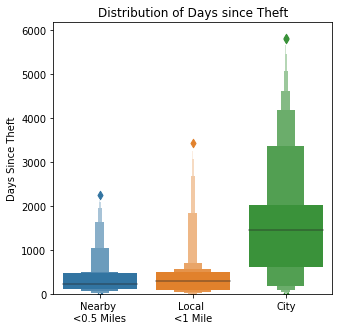

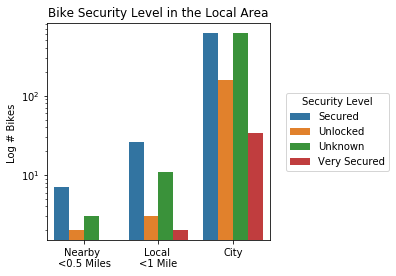

In [25]:
threats_nearby=search_near_me(user_street_address="3030 14th St NW, Washington, DC 20009", scale='medium', extra_plots=True )

# Note: Some versions of cartopy are have a known bug when accessing OSM, related to the google tiles code. 
#    If this occurs, please follow the guide below, or replace your cartopy file with the one provided.
#    https://stackoverflow.com/questions/57531716/valueerror-a-non-empty-list-of-tiles-should-be-provided-to-merge-cartopy-osm

In [8]:
threats_nearby.head()

Bike ID                                     Location  \
146    944331    1106 Columbia Rd NW, Washington, DC 20009   
535    755543        1712 14th St NW, Washington, DC 20009   
1066   742226           Monroe St NW, Washington, DC 20010   
2044   719288      2714 Quarry Rd NW, Washington, DC 20009   
5407   671789  1349 Euclid Street NW, Washington, DC 20009   

     Locking description                               Locking circumvented  \
146     U-lock and cable               Lock is missing, along with the bike   
535               U-lock               Lock is missing, along with the bike   
1066              U-lock  Object that bike was locked to was broken, rem...   
2044          Not locked               Lock is missing, along with the bike   
5407              U-lock                                Bike was not locked   

     Date stolen  ...  Distance  Lock_Status Time_Status Threat_Overall  \
146    2020.11.4  ...  0.428420            2          41      11.383366   
535     2020.6.3  ...  0.000000            2         195            inf   
1066   2020.5.22  ...  0.391406            2         207       2.468373   
2044   2020.4.24  ...  0.458055            1         235       0.928957   
5407  2019.10.28  ...  0.115954            2         414       4.166138   

     Lock_Time  
146   0.487686  
535   0.102559  
1066  0.096614  
2044  0.042551  
5407  0.048308  

[5 rows x 20 columns]

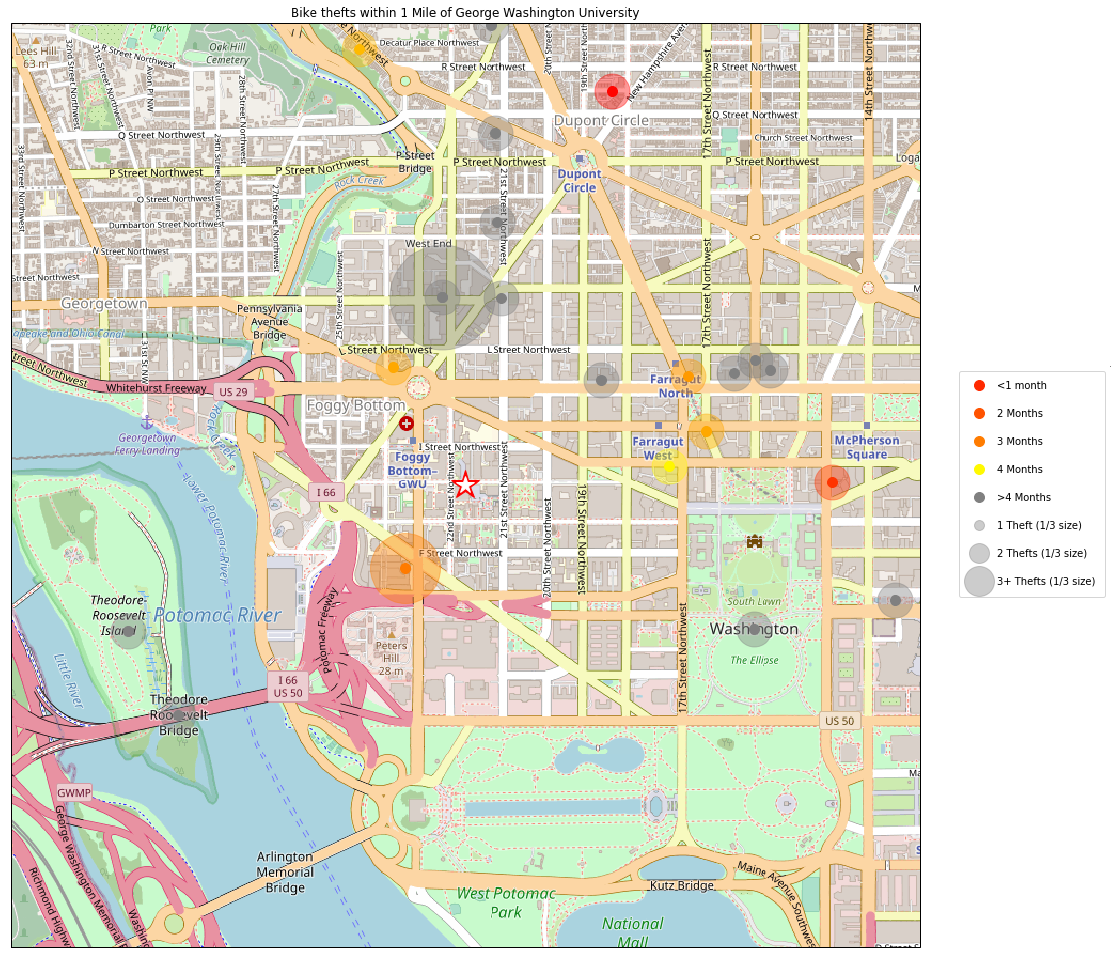

#  -----------  Relative Safety   -----------  #

  Your location is more safe than the local area.
  Your location is slightly more safe than the city in general.


#  -----------  Local Stats   -----------  #

 1.6% of bike thefts occurred within 0.5 miles. (23/1439)
 2.8% of bike thefts occurred within 1 mile. (40/1439)

 6/23 Bikes were locked.
 0/23 Bikes were highly secured.
 0/23 Bikes were explicitly unlocked.
 17/23 Bikes were unknown status.

 Closest stolen bike: 0.22 miles.
 Average stolen bike: 0.39 miles.

 Most recent theft: 89 days.
 Mean time to theft: 242 days.


#  -----------  OVERALL RECOMMENDATION   -----------  #

 Your current area is safer, or has similar theft risk to the local area.
 There is no need to park elsewhere.

 As always, exercise caution and lock your bike.

#  -------------------------------------------------  #



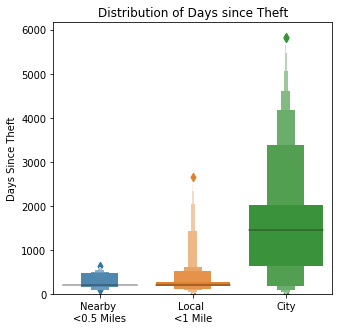

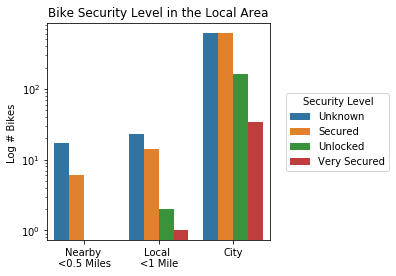

In [9]:
threats_nearby=search_near_me(user_street_address="George Washington University", scale='medium', extra_plots=True)

In [10]:

def plot_city_thefts(theft_nearby, city): 
    """
    Plots all bike thefts occuring in a city on a map centered on the epicenter of the city's thefts.
    Bike thefts are denoted by markers with a radius showing # of bikes stolen, and colour showing recency of theft (red -> yellow)
    Bikes stolen > 6 months ago are plotted in grey.
    
    Function takes the mean location of all thefts and plots centered on that location. 
    Does not plot thefts that had no location specified.
    
    Background image for the map is a streetmap from OpenStreetMaps
    Some versions of cartopy are have a known bug when accessing OSM, related to the google tiles code. 
    If this occurs, please follow the guide below, or replace your cartpy file with the one provided.
    https://stackoverflow.com/questions/57531716/valueerror-a-non-empty-list-of-tiles-should-be-provided-to-merge-cartopy-osm
    """    

    #Make sure there are thefts to plot. 
    #If not, still plot the location, but there will be no markers.
    if theft_nearby.shape[0]>0:
        #Get the radii and colours for all thefts
        theft_plot = theft_plot_transform(theft_nearby)
    
    #Initiate the figure
    fig = plt.figure(figsize=(15,19))
    
    #The base map will be from Open Street Maps
    imagery = OSM()
    
    #Use the OSM projection for positioning lat/longitude points
    ax = plt.axes(projection=imagery.crs, )
    
    # Set the extent - center on the user location +/- 1 mile
    long_adj = 1/54.6 * 5
    lat_adj  = 1/69 * 5
    
    #Center the plot on the mean theft value - Sometimes the default "city center" is far from town
    mean_lat=theft_plot.Latitude.mean()
    mean_long=theft_plot.Longitude.mean()
    
    ax.set_extent( (mean_long-long_adj, mean_long+long_adj,
                    mean_lat-lat_adj, mean_lat+lat_adj))
    
    
    if theft_nearby.shape[0]>0:
        #Plot all nearby bike thefts
        for i in range(theft_plot.shape[0]):
            plt.plot(theft_plot['Longitude'].iloc[i],theft_plot['Latitude'].iloc[i], color=theft_plot['Color'].iloc[i], markersize=theft_plot['Number'].iloc[i] * 20, marker='o', alpha=0.4, transform=ccrs.Geodetic() )
            plt.plot(theft_plot['Longitude'].iloc[i],theft_plot['Latitude'].iloc[i], color=theft_plot['Color'].iloc[i], markersize=10, marker='o',transform=ccrs.Geodetic() )
            
    
    # Add the imagery to the map.
    zoom = 13 
    ax.add_image(imagery, zoom )
    plt.title(f'Bike thefts in {city}')
    
    #Get colors and labels for the legend
    labels=theft_plot_transform(theft_nearby, labels=True)+['Grey']
    label_text=['<1 month', '2 Months', '3 Months', '4 Months', '>4 Months']
    theft_text=['1 Theft (1/3 size)','2 Thefts (1/3 size)', '3+ Thefts (1/3 size)',]
    
    #Add dummy axis to construct our legend
    legend_ax = fig.add_axes([1.05,0.6,0,0])
    legend_ax.axes.get_xaxis().set_visible(False)
    legend_ax.axes.get_yaxis().set_visible(False)
    
    #Add markers to dummy axis
    for i in range(len(labels)):
        legend_ax.plot(1,1, color=labels[i], label=label_text[i], markersize=10, marker='o',linestyle = 'None',)
       
    for i in range(1,4):
        legend_ax.plot(1,1, color='Grey', label=theft_text[i-1],
                       markersize=i*10, marker='o',linestyle = 'None', alpha=0.4)
    #Add legend
    legend_ax.legend(borderpad=1, labelspacing =1.8, columnspacing =2,)#bbox_to_anchor=(1.05, .7) )

    
    
    plt.show()
    

def search_my_city(city):
    #get location of city, then make sure all entries are from the correct city.    
    user_loc=get_user_loc(city)    
    theft_nearby=thefts_in_radius(user_loc, main_df, search_radius=10)
    theft_nearby=theft_nearby[theft_nearby["City"] == city]
    theft_nearby=calculate_risk(theft_nearby)
    #Plot
    plot_city_thefts(theft_nearby, city)



In [11]:
def city_overview(city, state, main_df):
    """
    Plots statistical overview of the thefts in a user-input city.
    Also requires State to ensure the proper city is plotted.
    """
    
    #Add columns to the dataframe with date/time information extracted from the datetime column for easy grouping
    city_df=main_df[(main_df.City == city) & (main_df.State == state)].copy()
    city_df['Year'] = city_df['DateTime'].dt.year
    city_df['Month'] = city_df['DateTime'].dt.month
    city_df['Day'] = city_df['DateTime'].dt.day
    city_df['Weekday'] = city_df['DateTime'].dt.dayofweek
    
    #Extract count information from the subsetted dataframe 
    count_year = city_df.groupby(['Year']).size().reset_index(name='Theft_Count')   
    count_month = city_df.groupby(['Month']).size().reset_index(name='Theft_Count')   
    count_day = city_df.groupby(['Day']).size().reset_index(name='Theft_Count')  
    count_weekday = city_df.groupby(['Year','Weekday']).size().reset_index(name='Theft_Count')  
    
    #Replace the numbers for day stings
    weekday_dict ={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',
                                   4:'Friday', 5:'Saturday', 6:'Sunday',}
    count_weekday.Weekday.replace(weekday_dict, inplace=True)  
    
    #Replace month numbers for strings
    count_month.Month.replace({	1 :'January',2:'February', 3:'March', 4:'April',
                                  5:'May', 6:'June', 7:'July', 8:'August', 9:'September',
                                  10:'October', 11:'November', 12:'December'}, inplace=True)
            
            
    #Plot total thefts per Year        
    fig = plt.figure(figsize=(13,4))
    sns.lineplot(data=count_year, x='Year', y='Theft_Count')
    plt.title(f'Total Annual Thefts in {city}', fontsize=13)
    plt.axvline(x=2013, color='orange',linestyle='dashed', label = 'Launch of BikeIndex')
    plt.ylabel('# Bikes')        
    plt.legend(loc='upper left')
    plt.show()
    
    
    
    def seperate_seasons(df_in, colors_only=False):
        """
        Divide months into  meteorological seasons
        This means that we use rounded-off months starting on the 1st
        """
        
        #Generate colours for plotting, and use keys as a list
        season_colours={'Winter':'#486BF9', 'Spring':'#48F97E', 'Summer':'#F9D648','Fall':'#F96648'}    
        seasons= season_colours.keys()
        seasons = [ele for ele in seasons for i in range(3)] 
        
        #Reorder the repeated seasons to match the actual seasons (i.e. December is in the winter.)
        dates=[i for i in range(1,12+1)]
        dates=dates[-1:]+dates[:11]
        dates=dict(zip(dates,seasons))
        
        #Replace the month input into a new season column
        df_in["Season"]=df_in.Month.replace(dates)
    
        return df_in, season_colours
    
    #Plot a barplot showing thefts per season
    fig = plt.figure(figsize=(13,4))
    city_df_months, color_dict=seperate_seasons(city_df)
    count_seasons = city_df.groupby(['Year', "Season"]).size().reset_index(name='Theft_Count') 
    count_seasons['Year'] = count_seasons['Year'].astype(int)
    
    #Plot
    sns.barplot(x="Year",y='Theft_Count', hue="Season", palette=color_dict, 
                 data=count_seasons, hue_order=color_dict.keys())
    plt.title(f'Seasonal Bike Thefts in {city}', fontsize=13)
    plt.ylabel('# Bikes')
    plt.legend(loc='upper left')          
    plt.show()
    
    
    
    
    
    def radial_plot(count_df, title_str, city_str):
        """
        Make a radial plot, can be used to show the monthly or weekly thefts
        """    
        
        #Get the labels (eg, weekday stings or month name strings) and stats (counts)
        labels=count_df.iloc[:,0].to_list()
        stats=count_df.iloc[:,1].to_list()
        
        
        #Get increments for the ticks - even intervals rounded to the nearest 50
        def tic_round(y):
            rounded= 50 * round(y/50)
            return int(rounded)
        #Divide into even intervals and apply rounding function
        tics_rough=np.linspace(1,1.2*max(stats), 5)
        tics=[tic_round(i) for i in tics_rough]
        
        #Divide nto angles
        angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
        
        # Need to add the first to the end to close the plot (or there will be a gap)
        stats=np.concatenate((stats,[stats[0]]))
        angles=np.concatenate((angles,[angles[0]]))
        
        #Plot
        fig=plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, polar=True)
        ax.plot(angles, stats, '-', linewidth=2, alpha=0.6)
        ax.fill(angles, stats, alpha=0.25)
        #ax.tick_params(pad=15) #Padding is not symettrical - ticks on the left side will be very far if the right is slightly off the circle.
        ax.set_thetagrids(angles * 180/np.pi, labels)
        plt.yticks(tics, [str(tic) for tic in tics], color="grey", size=8)
        plt.title(f'{title_str} Bike Thefts in {city} ', fontsize=13,y=1.08)
        
        #Show grid and show plot
        ax.grid(True)
        plt.show()
    
    #Plot the radial plot for the monthly thefts
    radial_plot(count_month, "Monthly", city)
    
    
    #PLot boxplots for thefts by day of the week
    fig = plt.figure(figsize=(8,3))
    sns.boxplot(data=count_weekday, x='Weekday', y='Theft_Count', palette="deep", order=weekday_dict.values())
    plt.ylim(0,count_weekday['Theft_Count'].max()*1.15 )
    plt.title(f'Thefts by Week Day in {city}')
    plt.ylabel('# Bikes')
    plt.show()

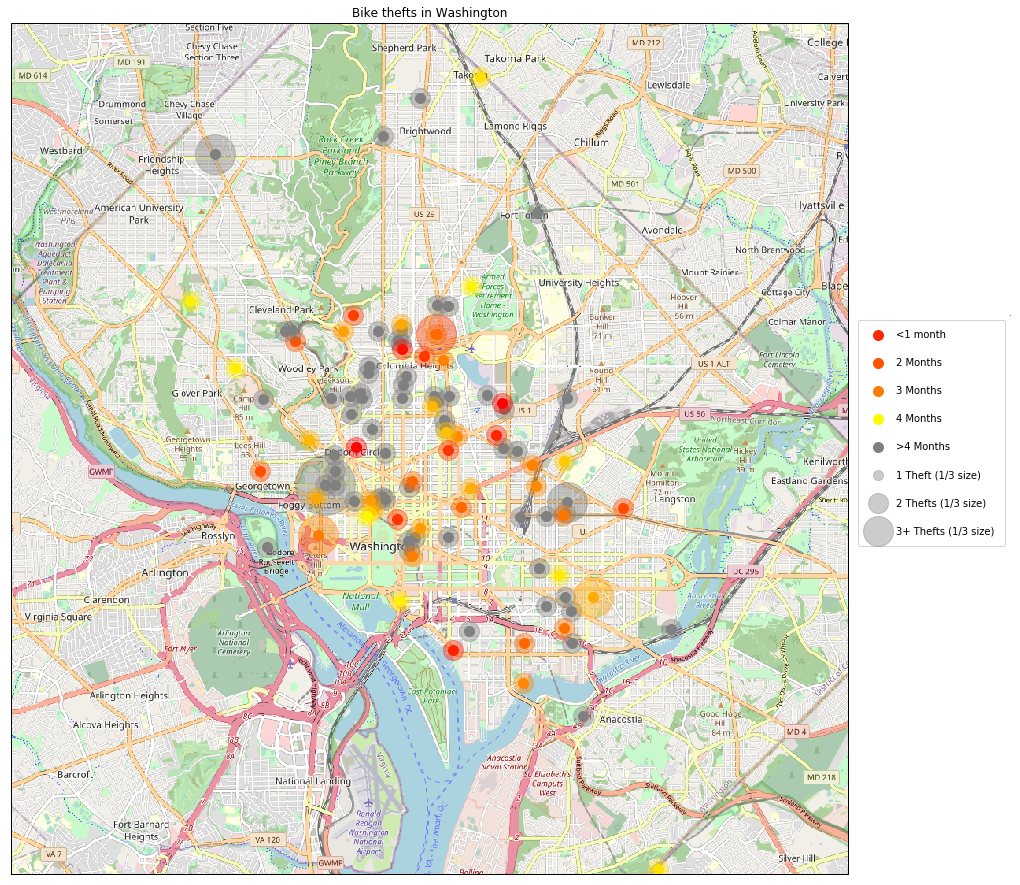

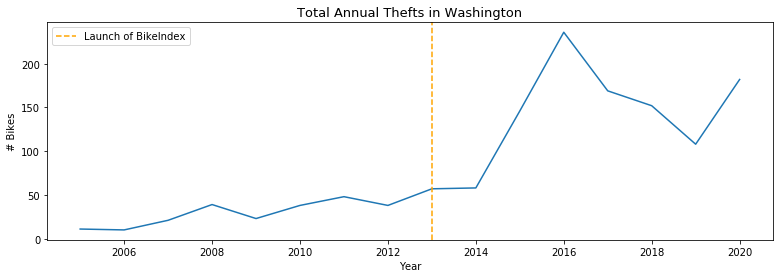

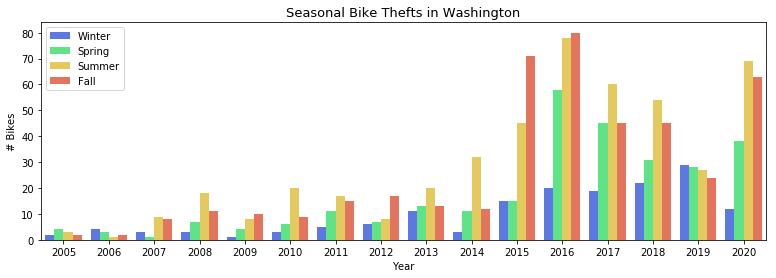

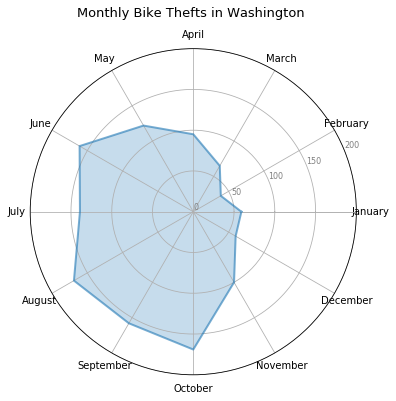

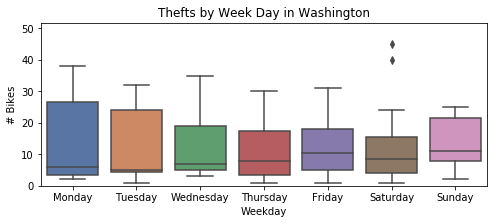

In [12]:
search_my_city('Washington')
city_overview(city='Washington', state='DC', main_df=main_df)

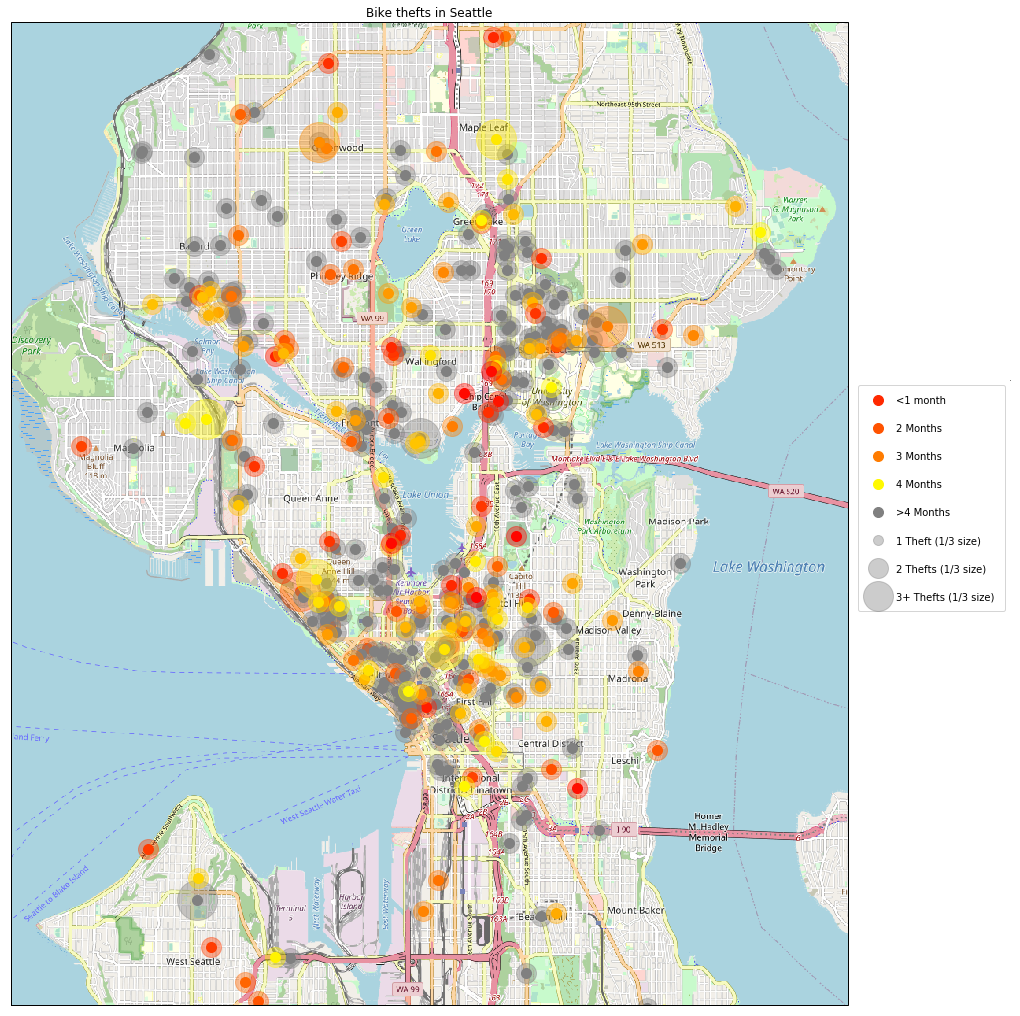

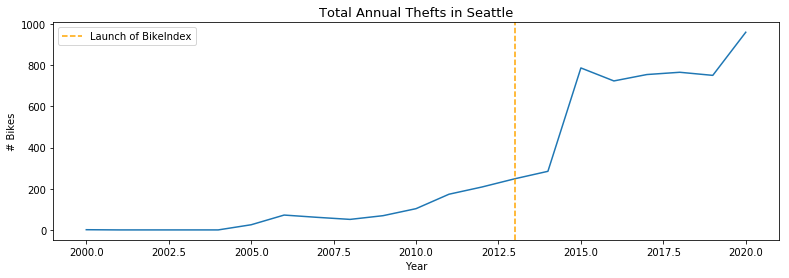

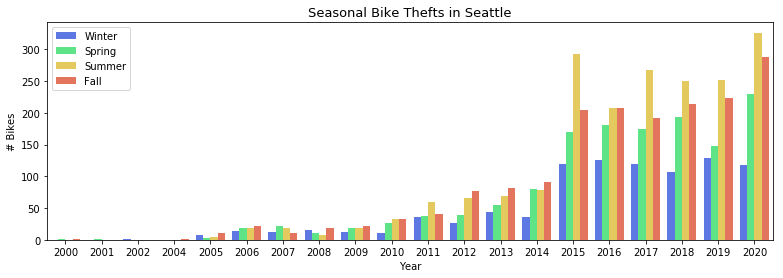

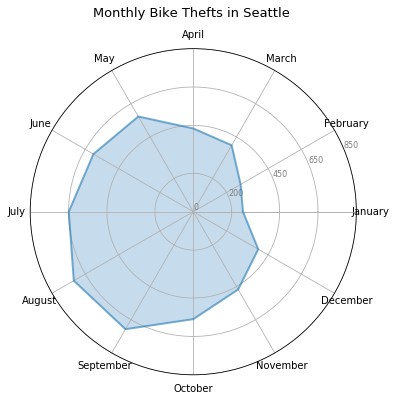

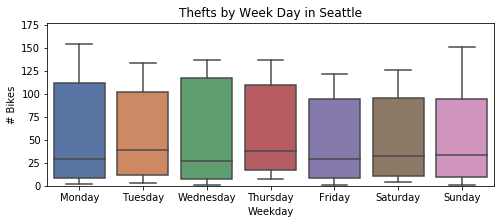

In [13]:
search_my_city('Seattle')
city_overview(city='Seattle', state='WA', main_df=main_df)

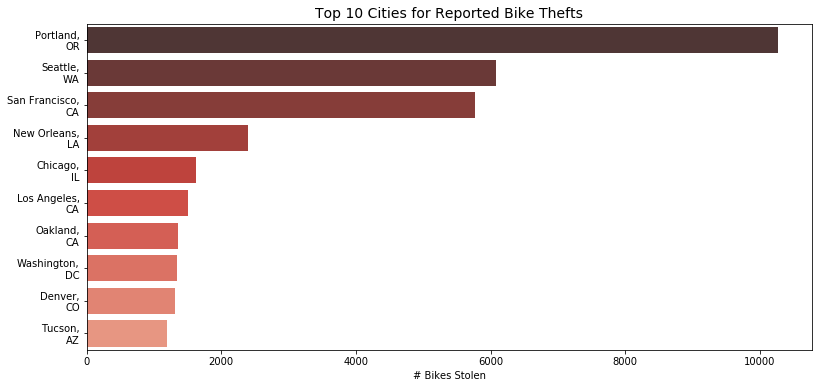

In [14]:
def top_10_plot(main_df):
    """
    Show the top 10 cities for bike thefts reported in the US
    Shown as a horizontal barplot
    """
    
    #Group by city and state, count the number of thefts in each.
    top10_thefts = main_df.groupby(["State", "City"]).size().reset_index(name='Theft_Count') 
    top10_thefts.sort_values("Theft_Count", inplace=True, ascending=False)
    
    #Get the 10 with the most thefts
    top10_thefts=top10_thefts.head(10)
    top10_thefts["Labels"]= top10_thefts["City"] + ',\n'+ top10_thefts["State"]
    
    #Plot
    fig = plt.figure(figsize=(13,6))
    sns.barplot(data=top10_thefts, y='Labels', x='Theft_Count', palette = "Reds_d")# ['red']+['grey']*9)
    plt.title(f'Top 10 Cities for Reported Bike Thefts', fontsize=14)
    plt.xlabel('# Bikes Stolen')
    plt.ylabel('')
    plt.show()
    
    

top_10_plot(main_df)
